# UNET 영상 분할 기초 - 이진 분류 영상 분할 
- images segmentation : UNET 네트웤의 모델 학습을 통해 이미지에서 원하는 부분만 분류 하는 것 
- 이 때 분류는 output이미지의 컬러 구성에 따라 결정 
- output이 0과1로 구성 된 grayscale의 경우 2진분류, 컬러의 경우 다중 분류를 사용 

**2진 분류 영상 분할**
- loss = 'binary_crossentropy', metrics = ['accuracy'], output activation = 'sigmoid'
- 예측한 값은 256,256각 픽셀들 각각의 예측 값이 계산 됨, 0에 가까우면 0 ,1에 가까우면 1 
- 반올림을 통해 0,1로 설정

## 데이터 로드 

In [ ]:
!rm -rf Lung_Segmentation.zip
!wget https://github.com/dhrim/MDC_2021/raw/master/material/deep_learning/Lung_Segmentation.zip

--2022-01-04 14:49:57--  https://github.com/dhrim/MDC_2021/raw/master/material/deep_learning/Lung_Segmentation.zip
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dhrim/MDC_2021/master/material/deep_learning/Lung_Segmentation.zip [following]
--2022-01-04 14:49:57--  https://raw.githubusercontent.com/dhrim/MDC_2021/master/material/deep_learning/Lung_Segmentation.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37648324 (36M) [application/zip]
Saving to: ‘Lung_Segmentation.zip’

Lung_Segmentation.z 100%[===================>]  35.90M  83.0MB/s    in 0.4s    

2022-01-04 14:49:59 (83.0 MB/s) 

In [ ]:
!rm -rf Lung_Segmentation
!unzip Lung_Segmentation.zip

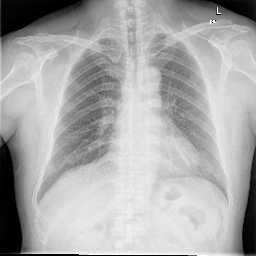

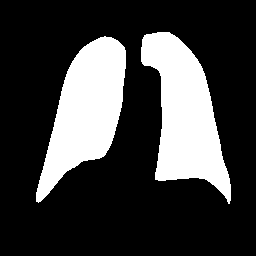

In [ ]:
from IPython.display import Image, display

display(Image('./Lung_Segmentation/image/CHNCXR_0001_0.png'))
display(Image('./Lung_Segmentation/label/CHNCXR_0001_0.png'))

In [ ]:
import numpy as np
import os

from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

data_path = "Lung_Segmentation"

files = os.listdir(os.path.join(data_path, 'image'))
# files = ['CHNCXR_0402_1.png', 'CHNCXR_0461_1.png', 'CHNCXR_0422_1.png', ... ]    


raw_x = []
raw_y = []
for file_name in files:
    # file_name = "CHNCXR_0402_1"

    # input_file = "./Lung_Segmentation/image/CHNCXR_0402_1.png"
    input_file = os.path.join(data_path, 'image', file_name)
    
    # output_file = "./Lung_Segmentation/label/CHNCXR_0402_1.png"
    output_file = os.path.join(data_path, 'label', file_name)
    
    image = imread(input_file)[:,:,:IMG_CHANNELS]
    # image.shape = (256, 256, 3)

    label = imread(output_file)
    # label.shape = (256, 256)

    label = np.expand_dims(label, axis=-1)
    # label.shape = (256, 256, 1)

    raw_x.append(image)
    raw_y.append(label)

raw_x = np.array(raw_x)
raw_y = np.array(raw_y)

In [ ]:
raw_x.shape

(566, 256, 256, 3)

In [ ]:
print(raw_x[0])

## 전처리 

### 정규화 

In [ ]:
x = (raw_x / 255).astype(np.float)
y = (raw_y / 255).astype(np.int)

In [ ]:
print(np.min(x), np.max(x))
print(np.min(y), np.max(y))

0.0 1.0
0 1


### 데이터 분할 

In [ ]:
split_index = int(x.shape[0]*0.8)
train_x, test_x = x[:split_index], x[split_index:]
train_y, test_y = y[:split_index], y[split_index:]

### 분할된 데이터 확인 

train


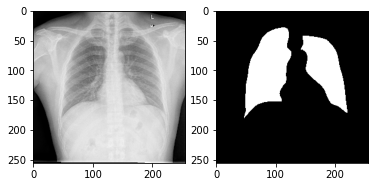

test


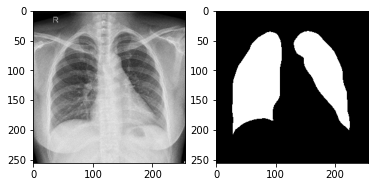

In [ ]:
import matplotlib.pyplot as plt

def plotTrainData(x, y, set_type):
    print(set_type)  
    for i in range(1):
        ix = np.random.randint(0, len(x))
        plt.subplot(1,2,1)
        plt.imshow(x[ix])
        
        plt.subplot(1,2,2)
        plt.imshow(np.squeeze(y[ix]), 'gray') # np.squeeze()는 (256,26,1)을 (256,256)으로 변환
        plt.show()
        
plotTrainData(train_x, train_y, 'train')
plotTrainData(test_x, test_y, 'test')

## 모델 

### UNET 모델 정의 
- one class UNET을 사용하는 경우 loss = mse, output activation = 'sigmoid' 사용 

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras import backend as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

def unet(input_size=(256,256,3)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    
    up = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5)
    up6 = concatenate([up, conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    
    up = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up, conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    
    up = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7)
    up8 = concatenate([up, conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    
    up = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8)
    up9 = concatenate([up, conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [ ]:
# 모델 생성
model = unet()

# 모델 컴파일
model.compile(loss="binary_crossentropy", optimizer="Adam", metrics=['accuracy'])

# 학습
hist = model.fit(train_x, train_y, validation_split=0.2, epochs=100, batch_size=32, verbose=1)

In [ ]:
y_ = model.predict(test_x)

In [ ]:
plt.imshow(test_y[0].squeeze(),'gray')

In [ ]:
temp = y_[0]

In [ ]:
temp[temp>=0.5]=1
temp[temp<0.5]=0

In [ ]:
plt.imshow(temp.squeeze(),'gray')

# MNET 영상 분할 기초 - 이진분류 영상분할 
- getFPDMNET(patchHeight,patchWidthm,ipch,outch) 
- 여기서 앞에 3개는 input 데이터 shape 관련 - > 256,256,3 이 값들임 
- 마지막 outch 는 마지막 output 에 들어가는 값으로 2진분류, binary_crossentropy를 사용할 경우 1
- 다항분류로 할 경우 category 값에 맞게 


In [ ]:
!pip install tensorflow-datasets
!pip install tfds-nightly

##모델정의

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Activation, Input, Conv2D, BatchNormalization, MaxPooling2D, Conv2DTranspose, concatenate, Dropout, UpSampling2D
from tensorflow.keras import backend as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K


def getFPDMNet(patchHeight, patchWidth, ipCh, outCh):

    # Input
    input1 = Input((patchHeight, patchWidth, ipCh))

    # Encoder
    conv1 = Conv2D(16, (3, 3), padding='same')(input1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Dropout(0.2)(conv1)

    conv1 = concatenate([input1, conv1], axis=-1)
    conv1 = Conv2D(16, (3, 3), padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    #
    input2 = MaxPooling2D(pool_size=(2, 2))(input1)
    conv21 = concatenate([input2, pool1], axis=-1)

    conv2 = Conv2D(32, (3, 3), padding='same')(conv21)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Dropout(0.2)(conv2)

    conv2 = concatenate([conv21, conv2], axis=-1)
    conv2 = Conv2D(32, (3, 3), padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    #
    input3 = MaxPooling2D(pool_size=(2, 2))(input2)
    conv31 = concatenate([input3, pool2], axis=-1)

    conv3 = Conv2D(64, (3, 3), padding='same')(conv31)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Dropout(0.2)(conv3)
    
    conv3 = concatenate([conv31, conv3], axis=-1)
    conv3 = Conv2D(64, (3, 3), padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    #
    input4 = MaxPooling2D(pool_size=(2, 2))(input3)
    conv41 = concatenate([input4, pool3], axis=-1)

    conv4 = Conv2D(128, (3, 3), padding='same')(conv41)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Dropout(0.2)(conv4)
    
    conv4 = concatenate([conv41, conv4], axis=-1)
    conv4 = Conv2D(128, (3, 3), padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Dropout(0.2)(conv4)

    conv4 = Conv2D(128, (3, 3), padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)

    # Decoder
    conv5 = UpSampling2D(size=(2, 2))(conv4)
    conv51 = concatenate([conv3, conv5], axis=-1)

    conv5 = Conv2D(64, (3, 3), padding='same')(conv51)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)
    conv5 = Dropout(0.2)(conv5)
    
    conv5 = concatenate([conv51, conv5], axis=-1)
    conv5 = Conv2D(64, (3, 3), padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)

    #
    conv6 = UpSampling2D(size=(2, 2))(conv5)
    conv61 = concatenate([conv2, conv6], axis=-1)

    conv6 = Conv2D(32, (3, 3), padding='same')(conv61)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation('relu')(conv6)
    conv6 = Dropout(0.2)(conv6)
    
    conv6 = concatenate([conv61, conv6], axis=-1)
    conv6 = Conv2D(32, (3, 3), padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation('relu')(conv6)

    #
    conv7 = UpSampling2D(size=(2, 2))(conv6)
    conv71 = concatenate([conv1, conv7], axis=-1)

    conv7 = Conv2D(16, (3, 3), padding='same')(conv71)
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation('relu')(conv7)
    conv7 = Dropout(0.2)(conv7)
    
    conv7 = concatenate([conv71, conv7], axis=-1)
    conv7 = Conv2D(16, (3, 3), padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation('relu')(conv7)

    # Final
    conv81 = UpSampling2D(size=(8, 8))(conv4)
    conv82 = UpSampling2D(size=(4, 4))(conv5)
    conv83 = UpSampling2D(size=(2, 2))(conv6)
    conv8 = concatenate([conv81, conv82, conv83, conv7], axis=-1)
    conv8 = Conv2D(outCh, (1, 1), activation='sigmoid')(conv8)

    ############
    model = Model(inputs=input1, outputs=conv8)

    # sgd = SGD(learning_rate=lrate, decay=decay_Rate, momentum=0.75, nesterov=True)
    # model.compile(optimizer=sgd, loss=my_loss)

    return model

## 학습

In [ ]:
x = (raw_x / 255).astype(np.float)
y = (raw_y / 255).astype(np.int).astype(np.float)

split_index = int(x.shape[0]*0.8)
train_x, test_x = x[:split_index], x[split_index:]
train_y, test_y = y[:split_index], y[split_index:]

In [ ]:
# 모델 생성
# model = unet()
model = getFPDMNet(patchHeight=256, patchWidth=256, ipCh=3, outCh=1)

# 모델 컴파일
# model.compile(loss="mse", optimizer="SGD", metrics=['accuracy'])

lrate = 0.1
decay_Rate = 1e-6

def my_loss(y_true, y_pred):
    l1_loss = K.mean(K.abs(y_pred - y_true))
    return l1_loss
sgd = SGD(learning_rate=lrate, decay=decay_Rate, momentum=0.75, nesterov=True)

model.compile(optimizer=sgd, loss=my_loss, metrics=['accuracy']) #<--- loss : mae 사용 


# 학습
hist = model.fit(train_x, train_y, validation_split=0.2, epochs=20, batch_size=8, verbose=1)


Epoch 1/20
46/46 [==============================] - 25s 231ms/step - loss: 0.0911 - accuracy: 0.9230 - val_loss: 0.4592 - val_accuracy: 0.6333
Epoch 2/20
46/46 [==============================] - 7s 159ms/step - loss: 0.0470 - accuracy: 0.9571 - val_loss: 0.5552 - val_accuracy: 0.3725
Epoch 3/20
46/46 [==============================] - 7s 160ms/step - loss: 0.0381 - accuracy: 0.9650 - val_loss: 0.5726 - val_accuracy: 0.4209
Epoch 4/20
46/46 [==============================] - 7s 162ms/step - loss: 0.0361 - accuracy: 0.9663 - val_loss: 0.7131 - val_accuracy: 0.2816
Epoch 5/20
46/46 [==============================] - 7s 163ms/step - loss: 0.0310 - accuracy: 0.9710 - val_loss: 0.6098 - val_accuracy: 0.3816
Epoch 6/20
46/46 [==============================] - 8s 164ms/step - loss: 0.0297 - accuracy: 0.9719 - val_loss: 0.3564 - val_accuracy: 0.6481
Epoch 7/20
46/46 [==============================] - 8s 166ms/step - loss: 0.0276 - accuracy: 0.9738 - val_loss: 0.2948 - val_accuracy: 0.7047
Epoch

In [ ]:
y_ = model.predict(test_x)

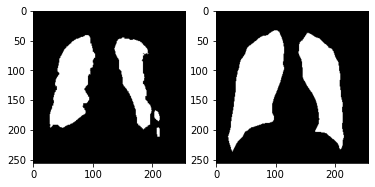

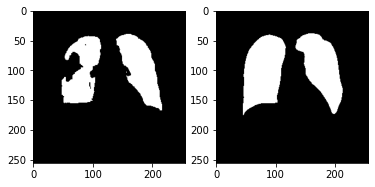

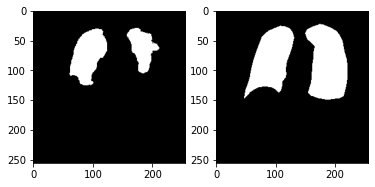

In [ ]:
for i in range(3):
  temp = y_[i]
  temp[temp>=0.5]=1
  temp[temp<0.5]=0
  plt.subplot(1,2,1)
  plt.imshow(temp.squeeze(),'gray')
  plt.subplot(1,2,2)
  plt.imshow(test_y[i].squeeze(),'gray')
  plt.show()

# UNET 영상 분할 기초- 컬러 영상 

## 모듈 

In [ ]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import os
import random
import cv2

from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from tensorflow.keras.layers import  Dropout, Activation
from tensorflow.keras.optimizers import Adam, SGD
# from tensorflow.keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model

## 데이터 로드 

In [ ]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xvzf images.tar.gz
!tar -xvzf annotations.tar.gz

In [ ]:
#불필요한 파일 제거 
!rm images/*.mat
!rm annotations/trimaps/._*

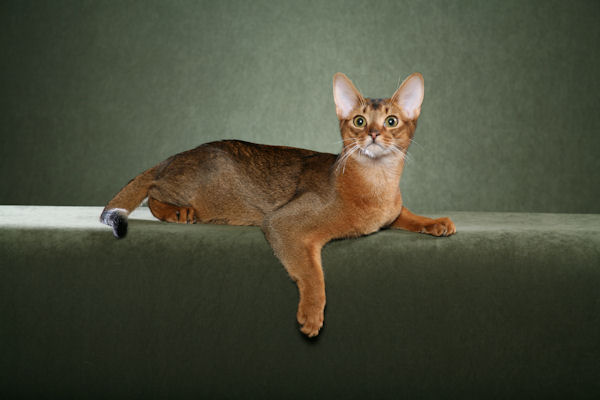

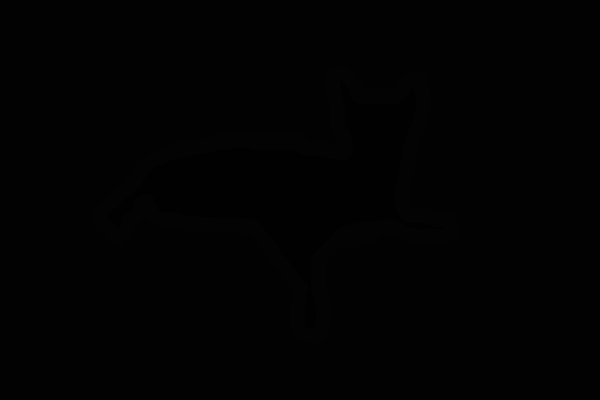

In [ ]:
# 파일 확인 
from IPython.display import Image, display

display(Image('images/Abyssinian_1.jpg'))
display(Image('annotations/trimaps/Abyssinian_1.png'))

- annoation 파일은 각 픽셀 별 category 값이 담긴 파일로 그냥 봐서는 보이지 않음 
- 이 경우 label 이미지의 category는 1,2,3

(400, 600)


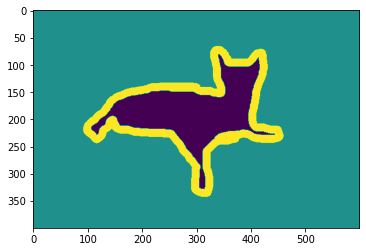

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3]


In [ ]:
label = cv2.imread('annotations/trimaps/Abyssinian_1.png', cv2.IMREAD_GRAYSCALE)
print(label.shape)
plt.imshow(label)
plt.show()
print(label[100][300:360])

녹색 : 2, 노랑 : 3, 보라 : 1 

category 값은 README 파일에 명시되어 있다.
- 1: 전경
- 2: 배경
- 3: 테두리

## 이미지 제너레이터 + 전처리 
- 3개의 카테고리 값을 두개로 통일 시켜 binary 케이스로 만듬 
- 테두리와 전경을 1로 통일 
- 배경은 0으로 



In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def image_preprocessor(image):  #<----- 정규화 
  # normalizing
  return image/255.0

def label_preprocessor(label): #<------ 카테고리 처리 
  # 전경/배경/이외의 구분을 전경/배경으로 바꾼다.
  label[ label==1 ] = 1  # 전경(1)은 1로
  label[ label==2 ] = 0  # 배경(2)은 0으로
  label[ label==3 ] = 1  # 이외(3)도 1로. 전경의 테두리 같다. 전경으로 치자.
  return label


img_generator = ImageDataGenerator(
    preprocessing_function=image_preprocessor,
    validation_split=0.2)


train_img_generator = img_generator.flow_from_directory(".", 
    classes=["images"],
    target_size=(256, 256), 
    batch_size=64,
    interpolation="nearest", #<--- 사이즈를 바꿀 때 값을 어떻게 매꿀 것인가를 결정, 보간법 
    class_mode=None,
    shuffle=True,
    subset='training',
    seed=42)

validation_img_generator = img_generator.flow_from_directory(".",
    classes=["images"],
    target_size=(256, 256), 
    batch_size=64,
    interpolation="nearest",
    class_mode=None,
    shuffle=True,
    subset='validation',
    seed=42)



label_generator = ImageDataGenerator(
    preprocessing_function=label_preprocessor,
    validation_split=0.2)


train_label_generator = label_generator.flow_from_directory(
    "annotations", 
    classes=["trimaps"], 
    target_size=(256, 256), 
    batch_size=64,
    interpolation="nearest",
    color_mode="grayscale",    
    class_mode=None,
    shuffle=True,
    subset='training',
    seed=42)


validation_label_generator = label_generator.flow_from_directory(
    "annotations", 
    classes=["trimaps"], 
    target_size=(256, 256), 
    batch_size=64,
    interpolation="nearest",
    color_mode="grayscale",    
    class_mode=None,
    shuffle=True,
    subset='validation',  
    seed=42)

train_data_generator = zip(train_img_generator, train_label_generator)
validation_data_generator = zip(validation_img_generator, validation_label_generator)



Found 5912 images belonging to 1 classes.
Found 1478 images belonging to 1 classes.
Found 5912 images belonging to 1 classes.
Found 1478 images belonging to 1 classes.


## 전처리 한 데이터 확인 
- 여기서 label의 값들은 0,1,2로만 구성되어 있기 때문에 따로 normalization 진행 x 

In [ ]:
batch_x, batch_y = next(train_data_generator)

print(batch_x.shape)
print(batch_y.shape)

(64, 256, 256, 3)
(64, 256, 256, 1)


In [ ]:
np.max(batch_y[0])

1.0

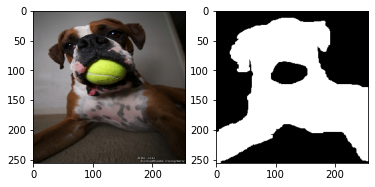

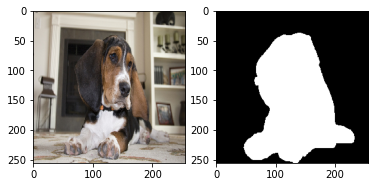

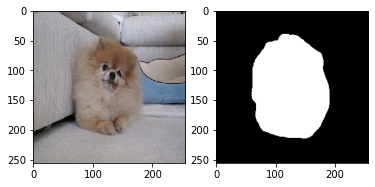

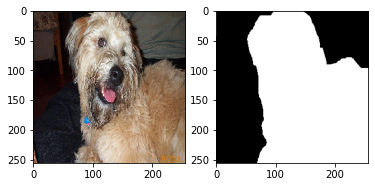

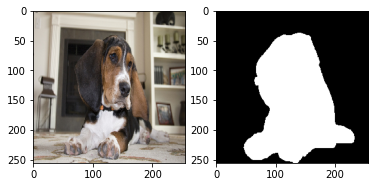

In [ ]:
import matplotlib.pyplot as plt

def plotTrainData(x, y):
    for i in range(5):
        ix = np.random.randint(0, len(x))
        plt.subplot(1,2,1)
        plt.imshow(x[ix])
        
        plt.subplot(1,2,2)
        plt.imshow(np.squeeze(y[ix]), 'gray') # np.squeeze()는 (256,26,1)을 (256,256)으로 변환
        plt.show()
   
plotTrainData(batch_x, batch_y)

## UNET 모델 

In [ ]:
def unet(sz = (256, 256, 3)):
  x = Input(sz)
  inputs = x
  
  # down sampling 
  f = 8
  layers = []
  
  for i in range(0, 6):
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    layers.append(x)
    x = MaxPooling2D() (x)
    f = f*2
  ff2 = 64 
  
  # bottleneck 
  j = len(layers) - 1
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
  x = Concatenate(axis=3)([x, layers[j]])
  j = j -1 
  
  # upsampling 
  for i in range(0, 5):
    ff2 = ff2//2
    f = f // 2 
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j -1 
    
  
  # classification 
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  outputs = Conv2D(1, 1, activation='sigmoid') (x)
  
  # model creation 
  model = Model(inputs=[inputs], outputs=[outputs])
  
  return model

In [ ]:
model = unet()

model.compile(optimizer = 'rmsprop', loss='binary_crossentropy',metrics = ['accuracy'])

hist = model.fit(
    train_data_generator,
    steps_per_epoch=train_img_generator.samples/64,
    validation_data=validation_data_generator,
    validation_steps=validation_img_generator.samples/64,
    epochs=10, 
    verbose=1)

Epoch 1/10
92/92 [==============================] - 68s 675ms/step - loss: 0.6711 - accuracy: 0.5990 - val_loss: 0.6004 - val_accuracy: 0.7118
Epoch 2/10
92/92 [==============================] - 56s 605ms/step - loss: 0.5836 - accuracy: 0.7192 - val_loss: 0.5500 - val_accuracy: 0.7443
Epoch 3/10
92/92 [==============================] - 61s 664ms/step - loss: 0.5190 - accuracy: 0.7581 - val_loss: 0.5552 - val_accuracy: 0.7213
Epoch 4/10
92/92 [==============================] - 56s 604ms/step - loss: 0.4985 - accuracy: 0.7675 - val_loss: 0.5278 - val_accuracy: 0.7366
Epoch 5/10
92/92 [==============================] - 54s 589ms/step - loss: 0.4896 - accuracy: 0.7717 - val_loss: 0.4901 - val_accuracy: 0.7652
Epoch 6/10
92/92 [==============================] - 54s 591ms/step - loss: 0.4686 - accuracy: 0.7817 - val_loss: 0.4918 - val_accuracy: 0.7660
Epoch 7/10
92/92 [==============================] - 55s 592ms/step - loss: 0.4356 - accuracy: 0.8037 - val_loss: 0.4516 - val_accuracy: 0.7980

## 테스트 결과 확인 

In [ ]:
import matplotlib.pyplot as plt

def plotPredictions(model, x, y):

  predicted = model.predict(x)
  predicted = (predicted > 0.5).astype(np.uint8)

  for i in range(5):

    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    plt.title("image")
    plt.axis('off')
    plt.imshow(x[i])
    plt.subplot(1,3,2)
    plt.title("label")
    plt.axis('off')
    plt.imshow(y[i].squeeze(), 'gray')
    plt.subplot(1,3,3)
    plt.title("predicted")    
    plt.axis('off')
    plt.imshow(predicted[i].squeeze(), 'gray')
    plt.show()

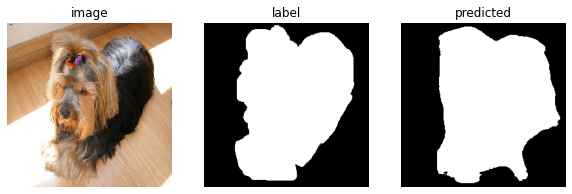

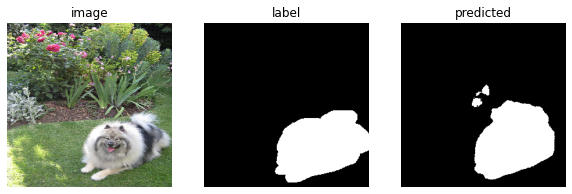

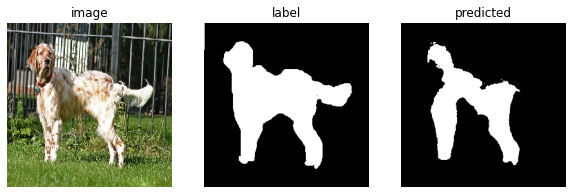

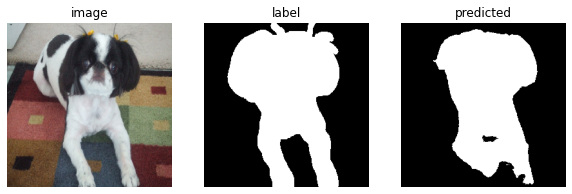

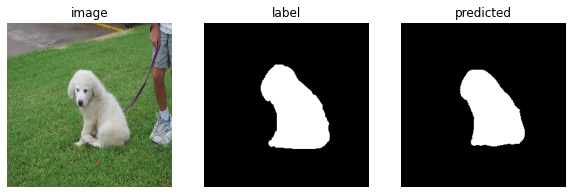

In [ ]:
plotPredictions(model, batch_x, batch_y)

# UNET 영상 분할 기초 - 다중 분류 

## 데이터 로드 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import tensorflow_datasets as tfds


ds = tfds.load('lost_and_found', split='train', batch_size=200)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1036 [00:00<?, ? examples/s]

Shuffling lost_and_found-train.tfrecord...:   0%|          | 0/1036 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/1203 [00:00<?, ? examples/s]

Shuffling lost_and_found-test.tfrecord...:   0%|          | 0/1203 [00:00<?, ? examples/s]

Dataset lost_and_found downloaded and prepared to /root/tensorflow_datasets/lost_and_found/semantic_segmentation/1.0.0. Subsequent calls will reuse this data.


In [ ]:
dataset = next(iter(ds))

In [ ]:
print(dataset.keys())

dict_keys(['image_id', 'image_left', 'segmentation_label'])


In [ ]:
images = dataset['image_left'].numpy()
labels = dataset['segmentation_label'].numpy()

In [ ]:
print(images.shape)
print(labels.shape)

(200, 1024, 2048, 3)
(200, 1024, 2048, 1)


In [ ]:
print(np.max(labels), np.min(labels))

38 0


- 38 ~ 0 이 label 의 카테고리 수 임 
- 카테고리 수 : 39개 

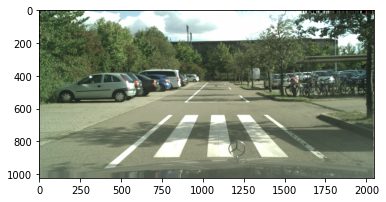

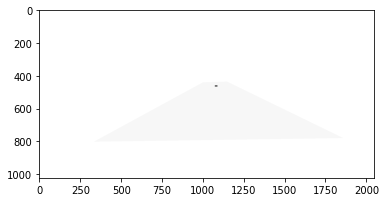

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(images[0])
plt.show()

plt.imshow(labels[0].squeeze(), cmap='binary')
plt.show()

## 전처리 

### 리사이즈 

In [ ]:
# from skimage.transform import resize
import cv2

def resize(img):
    return cv2.resize(img, (256,256), interpolation=cv2.INTER_NEAREST)

resized_images = np.array([resize(image) for image in images])
resized_labels = np.array([resize(label) for label in labels])

print(resized_images.shape)
print(resized_labels.shape)

(200, 256, 256, 3)
(200, 256, 256)


### 정규화 

In [ ]:
temp = resized_labels[0]

In [ ]:
import pandas as pd 
pd.DataFrame(temp).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256 entries, 0 to 255
Columns: 256 entries, 0 to 255
dtypes: uint8(256)
memory usage: 64.1 KB


In [ ]:
x = resized_images.astype(np.float) / 255.
y = resized_labels.astype(np.int)

### 데이터 분할 

In [ ]:
CATEGORY_COUNT = np.max(y) + 1
print("CATEGORY_COUNT =", CATEGORY_COUNT)

CATEGORY_COUNT = 39


In [ ]:
split_index = int(x.shape[0]*0.8)
train_x, test_x = x[:split_index], x[split_index:]
train_y, test_y = y[:split_index], y[split_index:]

In [ ]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(160, 256, 256, 3)
(160, 256, 256)
(40, 256, 256, 3)
(40, 256, 256)


### 전처리 후 데이터 확인 

train


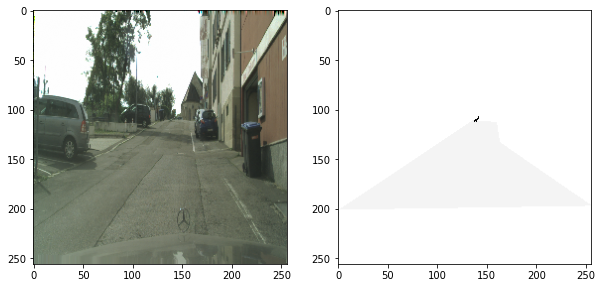

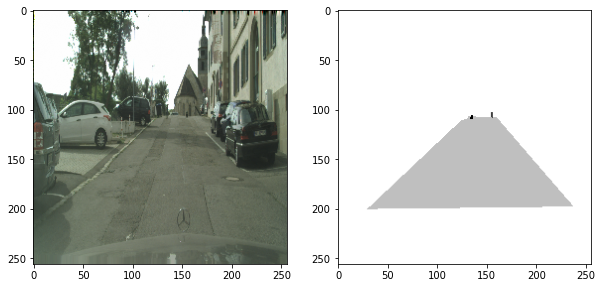

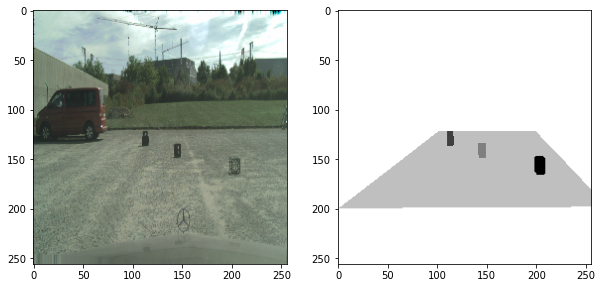

test


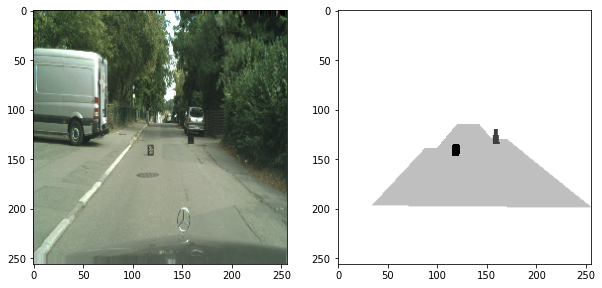

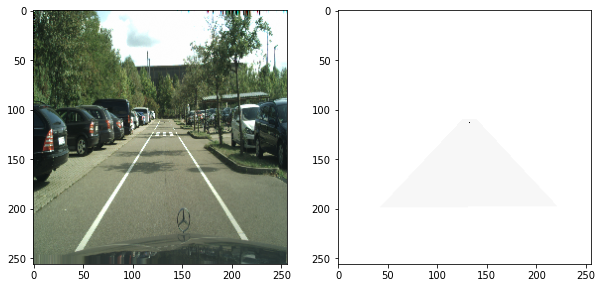

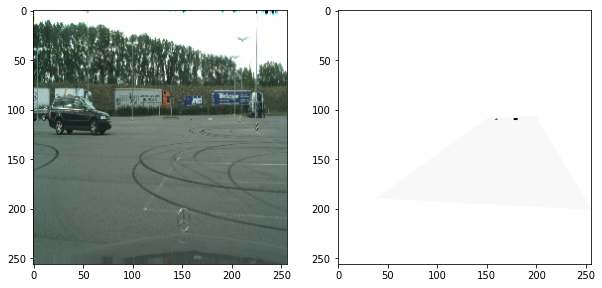

In [ ]:
import matplotlib.pyplot as plt

def plotTrainData(x, y, set_type):
    print(set_type)  
    for i in range(3):
        plt.figure(figsize=(10,5))
        ix = np.random.randint(0, len(x))
        plt.subplot(1,2,1)
        plt.imshow(x[ix])
        
        plt.subplot(1,2,2)
        plt.imshow(np.squeeze(y[ix]), 'binary') # np.squeeze()는 (256,26,1)을 (256,256)으로 변환
        plt.show()
        
plotTrainData(train_x, train_y, 'train')
plotTrainData(test_x, test_y, 'test')

## UNET 모델 정의 
- 멀티라벨은 이진 분류와는 다르게 UNET 정의 시 카테고리 수도 같이 입력 해줌
- 이 카테고리수는 output에 사용 됨 
- loss 도 sparse_categorical_crossentropy, activation도 softmax를 사용 

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras import backend as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

def unet(category_count, input_size=(256,256,3)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    
    up = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5)
    up6 = concatenate([up, conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    
    up = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up, conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    
    up = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7)
    up8 = concatenate([up, conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    
    up = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8)
    up9 = concatenate([up, conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)

    conv10 = Conv2D(category_count, (1, 1), activation="softmax")(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [ ]:
model = unet(CATEGORY_COUNT)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_88 (Conv2D)             (None, 256, 256, 32  896         ['input_9[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_30 (BatchN  (None, 256, 256, 32  128        ['conv2d_88[0][0]']              
 ormalization)                  )                                                           

In [ ]:
# 컴파일
model.compile(loss="sparse_categorical_crossentropy", optimizer="Adam", metrics=['accuracy'])

# 학습
hist = model.fit(train_x, train_y, validation_split=0.2, epochs=500, batch_size=64, verbose=1)

In [ ]:
y_ = model.predict(test_x)
predicted = np.argmax(y_,axis=-1)

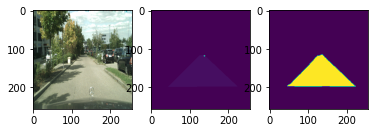

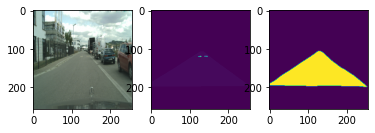

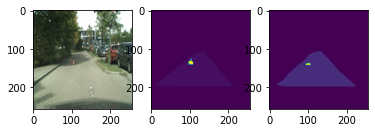

In [ ]:
for i in range(3):
  plt.subplot(1,3,1)
  plt.imshow(test_x[i])
  plt.subplot(1,3,2)
  plt.imshow(test_y[i])
  plt.subplot(1,3,3)
  plt.imshow(predicted[i])
  plt.show()